In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [3]:
# Number of samples. 
n = 1000
# Generate "time" variable. 
t = np.arange(n)

data_df = pd.DataFrame({'t' : t})

# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    y1 = amplitude * np.sin((2*np.pi)*t/period) 
    return y1

# Add two seasonal components. 
data_df['s1'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=2, period=40))

# Define target variable. 
data_df['y1'] = data_df['s1']

In [4]:
data_df

,t,s1,y1
0,0,0.000000,0.000000
1,1,0.312869,0.312869
2,2,0.618034,0.618034
3,3,0.907981,0.907981
4,4,1.175571,1.175571
...,...,...,...
995,995,-1.414214,-1.414214
996,996,-1.175571,-1.175571
997,997,-0.907981,-0.907981
998,998,-0.618034,-0.618034


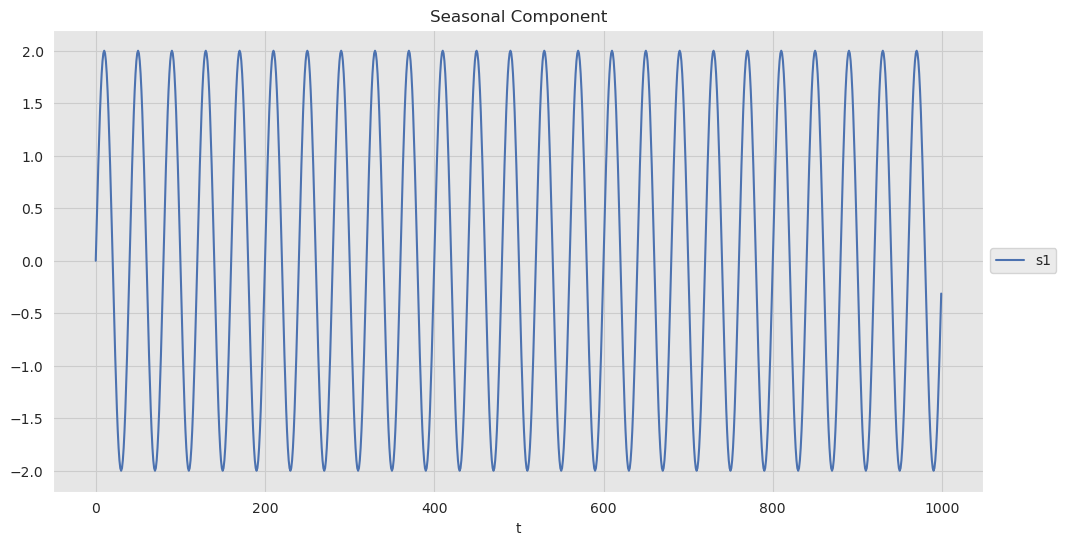

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='s1', data=data_df, color=sns_c[0], label='s1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Seasonal Component', xlabel='t', ylabel='')

In [6]:
# Set noise standard deviation. 
sigma_n = 0.3

data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
# Add noise to target variable. 
data_df ['y1'] = data_df ['y1'] + data_df ['epsilon']

[Text(0.5, 1.0, 'Sample Data 1'), Text(0.5, 0, 't'), Text(0, 0.5, '')]

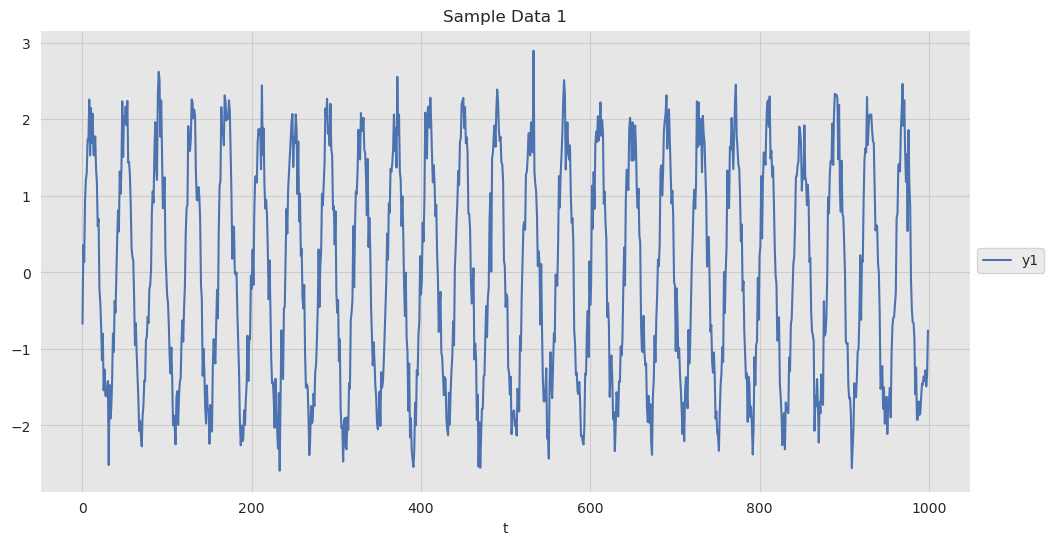

In [7]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 1', xlabel='t', ylabel='')

In [9]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

kernel_1  = k0 + k1

kernel_1

WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40)

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

X = data_df['t'].values.reshape(n, 1)
y = data_df['y1'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

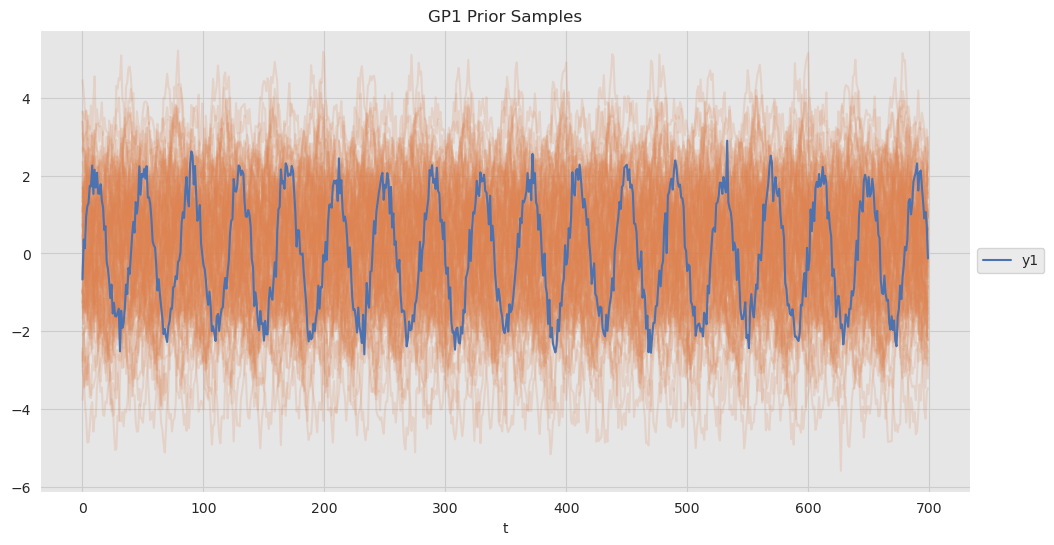

In [12]:
gp1_prior_samples = gp1.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp1_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP1 Prior Samples', xlabel='t')

In [13]:
gp1.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                         n_restarts_optimizer=10, normalize_y=True)

In [14]:
# Generate predictions.
y_pred, y_std = gp1.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - 2*data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + 2*data_df['y_std']

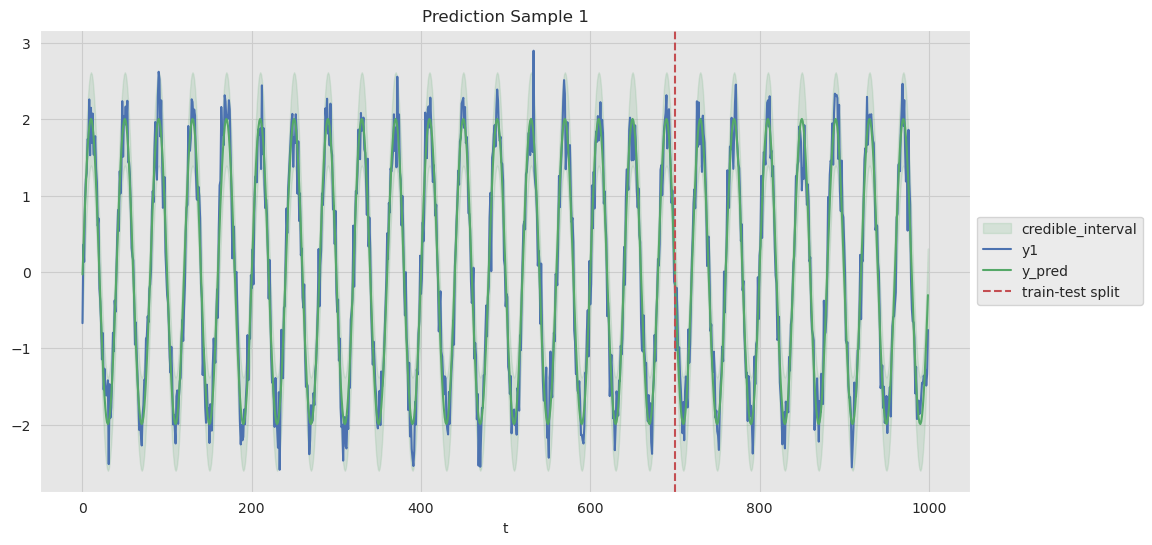

In [15]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label = 'y1', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='')

In [16]:
from sklearn.metrics import mean_absolute_error
print(f'R2 Score Train = {gp1.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp1.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp1.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp1.predict(X_test)): 0.3f}')

R2 Score Train =  0.956
R2 Score Test =  0.953
MAE Train =  0.245
MAE Test =  0.249


/tmp/ipykernel_15373/4239692173.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=errors, ax=ax[1])


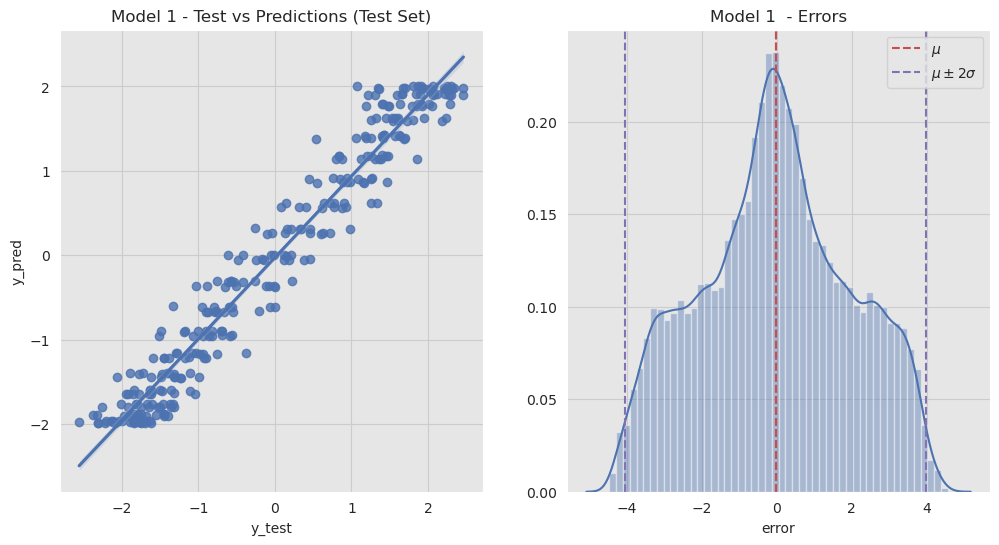

In [17]:
errors = gp1.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp1.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 1 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 1  - Errors', xlabel='error', ylabel=None);